In [1]:
import torch
import torch.nn as nn
import pandas as pd
from tqdm.notebook import tqdm  # For displaying progress bars
from datasets import load_dataset  # For loading datasets
from sklearn.model_selection import train_test_split  # For splitting the dataset
from transformers import BertTokenizer  # For tokenizing text
from torch.utils.data import TensorDataset  # For creating Tensor datasets
import time  # For measuring time
from sklearn.metrics import accuracy_score, precision_score, f1_score  # For evaluation metrics
from sklearn.exceptions import UndefinedMetricWarning  # For handling metric warnings
import matplotlib.pyplot as plt  # For plotting
from tabulate import tabulate  # For tabular data formatting
import random  # For randomization
import numpy as np  # For numerical operations
from transformers import (
    BertTokenizer,  # Tokenizer for BERT models
    AdamW,  # Optimizer for BERT models
    get_linear_schedule_with_warmup,  # Learning rate scheduler for BERT models
    BertConfig,  # Configuration for BERT models
    BertForSequenceClassification  # BERT model for sequence classification tasks
)
from torch.utils.data import (
    DataLoader,  # Data loader for creating batches
    RandomSampler,  # Sampler for random sampling of data
    SequentialSampler  # Sampler for sequential sampling of data
)
from sklearn.metrics import f1_score  # For computing the F1 score
import pandas as pd
import seaborn as sns
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
# 1. Torch: PyTorch library for deep learning
# 2. Pandas: Library for data manipulation and analysis
# 3. tqdm: Library for displaying progress bars
# 4. datasets: Library for working with datasets
# 5. train_test_split: Function for splitting the dataset into training and validation sets
# 6. BertTokenizer: Tokenizer for BERT models
# 7. TensorDataset: Dataset class for creating PyTorch Tensor datasets
# 8. time: Module for measuring time
# 9. accuracy_score, precision_score, f1_score: Evaluation metrics for classification tasks
# 10. UndefinedMetricWarning: Warning for undefined metric values
# 11. matplotlib.pyplot: Plotting library
# 12. tabulate: Library for formatting tabular data
# 13. random: Module for randomization
# 14. numpy: Library for numerical operations
# 15. AdamW: Optimizer for BERT models
# 16. get_linear_schedule_with_warmup: Learning rate scheduler for BERT models
# 17. BertConfig: Configuration for BERT models
# 18. BertForSequenceClassification: BERT model for sequence classification tasks
# 19. DataLoader: Data loader for creating batches
# 20. RandomSampler: Sampler for random sampling of data
# 21. SequentialSampler: Sampler for sequential sampling of data
# 22. f1_score: Function for computing the F1 score

2023-08-01 19:54:35.287563: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-01 19:54:37.658715: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 19:54:40.656309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def count_words(text):
    words = word_tokenize(text)
    return len(words)

def datacleaning_amazon():
    dataset = load_dataset("amazon_us_reviews", "Apparel_v1_00")
    train_data = dataset['train']

    train_data = train_data.select(range(50000))

    # Filter rows with review_body length less than or equal to 256 words
    train_data = train_data.filter(lambda example: count_words(example['review_body']) <= 256)

    # Limit the dataset to the first 10,000 rows
    train_data = train_data.select(range(10000))

    df = train_data.to_pandas()  # Convert the dataset to a Pandas DataFrame
    df = df[['customer_id', 'review_headline', 'review_body', 'star_rating']]  # Select specific columns
    df.columns = ['customer_id', 'review_headline', 'review_body', 'star_rating']  # Rename the selected columns
    df.set_index('customer_id', inplace=True)

    df['sentiment'] = df['star_rating'].map({5: 'good', 4: 'good', 3: 'neutral', 2: 'bad', 1: 'bad'})

    possible_labels = df.sentiment.unique()  # Get unique category labels from the DataFrame column 'category'

    label_dict = {}  # Create a dictionary to map each possible label to a unique index
    for index, possible_label in enumerate(possible_labels):
        label_dict[possible_label] = index

    df['label'] = df.sentiment.replace(label_dict)

    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        df.index.values,
        df.label.values,
        test_size=0.15,
        random_state=17,
        stratify=df.label.values
    )

    df['data_type'] = ['not_set'] * df.shape[0]  # Set a new column 'data_type' for later data split

    # Set the 'data_type' column of the dataframe for training and validation data
    df.loc[X_train, 'data_type'] = 'train'
    df.loc[X_val, 'data_type'] = 'val'

    return df

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten() #This line finds the index with the highest probability in each prediction, effectively giving the predicted class for each input.
    labels_flat = labels.flatten()  #This line flattens the labels array into a 1D vector, as required by the f1_score function.
    return f1_score(labels_flat, preds_flat, average='weighted') #This line computes the F1 score using the true labels and the predicted labels, with the weighted averaging scheme. The result is returned.

def accuracy_per_class(preds, labels, label_dict):
    # Create a dictionary with keys and values reversed for easy lookup.
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    # Get the predicted labels and flatten them.
    preds_flat = np.argmax(preds, axis=1).flatten()
    
    # Get the actual labels and flatten them.
    labels_flat = labels.flatten()

    # Initialize the confusion matrix.
    num_classes = len(label_dict)
    confusion_mat = confusion_matrix(labels_flat, preds_flat, labels=list(range(num_classes)))
    
    # Calculate accuracy and F1 score per class
    accuracies = {}
    f1_scores = {}
    for label in range(num_classes):
        # Calculate accuracy for this class
        num_correct = confusion_mat[label, label]
        num_instances = np.sum(confusion_mat[label, :])
        accuracy = num_correct / num_instances * 100
        accuracies[label] = accuracy
        
        # Calculate F1 score for this class
        f1 = f1_score(labels_flat, preds_flat, labels=[label], average='weighted')
        f1_scores[label] = f1

        # Print the class name, accuracy numerator, and denominator.
        class_name = label_dict_inverse[label]
        print(f'Class: {class_name}')
        print(f'Accuracy: {num_correct}/{num_instances} ({accuracy:.2f}%)')
        print(f'F1 Score: {f1:.2f}\n')

    # Calculate total accuracy and F1 score
    total_accuracy = accuracy_score(labels_flat, preds_flat) * 100
    total_f1_score = f1_score(labels_flat, preds_flat, average='weighted')

    # Print the total accuracy and F1 score
    print(f'Total Accuracy: {total_accuracy:.2f}%')
    print(f'Total F1 Score: {total_f1_score:.2f}')


#This code evaluates the performance of a trained model on a validation dataset by computing its loss and predictions for each batch in the dataset.
def evaluate(dataloader_val):

    model.eval() # setting the model to evaluation mode to disable dropout and other regularization techniques that are useful during training but not during evaluation.
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
    
        batch = tuple(b.to(device) for b in batch) # moving the input batch to the GPU for faster computation.
   
        #  creating a dictionary of inputs that will be passed to the model. The input IDs and attention mask are for the BERT model, and the labels are the true labels for each input.
        inputs = {'input_ids':  	batch[0],
                'attention_mask': batch[1],
                'labels':     	batch[2],
                } 

        with torch.no_grad():   
            outputs = model(**inputs)
        
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val)
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
       	 
    return loss_val_avg, predictions, true_vals

def train_model(trainer, dataloader_train, dataloader_val, epochs, patience):
    total_training_time = 0
    
    training_loss_list = []
    validation_loss_list = []
    accuracy_list = []
    precision_list = []
    f1_score_list = []
    
    previous_results = None  # Store previous epoch results
    best_val_loss = float('inf')
    counter = 0
    
    for epoch in tqdm(range(1, epochs + 1)):
        start_time = time.time()
    
        model.train()
        loss_train_total = 0
    
        progress_bar = tqdm(dataloader_train,
                            desc='Epoch {:1d}'.format(epoch),
                            leave=False,
                            disable=False)
        for batch in progress_bar:
            model.zero_grad()
            batch = tuple(b.to(device) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2],
            }
            output = model(**inputs)
            loss = output[0]
            loss_train_total += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
    
        end_time = time.time()
        epoch_training_time = end_time - start_time
        total_training_time += epoch_training_time
    
        torch.save(model.state_dict(), f'Models/finetuned_bert_lstm_amazon_ft_epoch{epoch}.model')
    
        tqdm.write(f'\nEpoch {epoch}')
    
        loss_train_avg = loss_train_total / len(dataloader_train)
        tqdm.write(f'Training loss: {loss_train_avg}')
    
        val_loss, predictions, true_vals = evaluate(dataloader_val)
    
        # Convert predictions to discrete labels
        predictions = np.argmax(predictions, axis=1)
    
        val_f1 = f1_score(true_vals, predictions, average='weighted')
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'F1 Score (weighted): {val_f1}')
    
        val_accuracy = accuracy_score(true_vals, predictions)
        val_precision = precision_score(true_vals, predictions, average='weighted', zero_division=1)
    
        # Compute and store metrics
        training_loss_list.append(loss_train_avg)
        validation_loss_list.append(val_loss)
        f1_score_list.append(val_f1)
        accuracy_list.append(val_accuracy)
        precision_list.append(val_precision)
    
        # Check if there are previous results to compare with
        if previous_results is not None:
            if loss_train_avg > previous_results['loss_train_avg']:
                percentage_increase = ((loss_train_avg - previous_results['loss_train_avg']) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Training loss increased compared to the previous epoch' + '\033[0m')
            if loss_train_avg < previous_results['loss_train_avg']:
                percentage_decrease = ((previous_results['loss_train_avg'] - loss_train_avg) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Training loss decreased compared to the previous epoch' + '\033[0m')
            if val_loss > previous_results['val_loss']:
                percentage_increase = ((val_loss - previous_results['val_loss']) / previous_results['val_loss']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Validation loss increased compared to the previous epoch' + '\033[0m')
            if val_loss < previous_results['val_loss']:
                percentage_decrease = ((previous_results['val_loss'] - val_loss) / previous_results['val_loss']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Validation loss decreased compared to the previous epoch' + '\033[0m')
            if val_f1 < previous_results['val_f1']:
                percentage_decrease = ((previous_results['val_f1'] - val_f1) / previous_results['val_f1']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_decrease, 2)}% F1 Score decreased compared to the previous epoch' + '\033[0m')
            if val_f1 > previous_results['val_f1']:
                percentage_increase = ((val_f1 - previous_results['val_f1']) / previous_results['val_f1']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_increase, 2)}% F1 Score increased compared to the previous epoch' + '\033[0m')
    
        # Store current results as previous results for the next epoch
        previous_results = {
            'loss_train_avg': loss_train_avg,
            'val_loss': val_loss,
            'val_f1': val_f1
        }
        
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                tqdm.write('\nEarly stopping triggered. Training stopped.')
                break
    
    total_time_minutes = total_training_time / 60
    tqdm.write(f'\nTotal training time: {total_time_minutes} minutes')
    
    final_accuracy = accuracy_list[-1]
    final_precision = precision_list[-1]
    tqdm.write(f'Final Accuracy: {final_accuracy}')
    tqdm.write(f'Final Precision: {final_precision}')
    
    # Create the x-axis values based on the actual number of epochs completed
    x_values = range(1, len(training_loss_list) + 1)
    
    # Create the metrics subplot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot training loss
    ax.plot(x_values, training_loss_list, label='Training Loss')
    
    # Plot validation loss
    ax.plot(x_values, validation_loss_list, label='Validation Loss')
    
    # Plot F1-score
    ax.plot(x_values, f1_score_list, label='F1 Score')

    # Plot Accuracy
    ax.plot(x_values, accuracy_list, label='Accuracy')
    
    # Set labels and title
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metric Value')
    ax.set_title('Training Loss, Validation Loss, and F1 Score')
    
    # Set legend
    ax.legend()
    
    # Show the combined plot
    plt.show()
    
    
    # Create the metrics table
    metrics_table = [
        ['Epoch', 'Training Loss', 'Validation Loss', 'F1 Score', 'Accuracy', 'Precision'],
    ]
    previous_results = None
    for epoch in range(1, len(training_loss_list) + 1):
        row = [
            epoch,
            training_loss_list[epoch - 1],
            validation_loss_list[epoch - 1],
            f1_score_list[epoch - 1],
            accuracy_list[epoch - 1],
            precision_list[epoch - 1]
        ]
    
        # Compare with previous epoch results
        if previous_results is not None:
            if training_loss_list[epoch - 1] < previous_results['loss_train_avg']:
                row[1] = '\033[92m' + str(row[1]) + '\033[0m'  # Highlight in green
            if training_loss_list[epoch - 1] > previous_results['loss_train_avg']:
                row[1] = '\033[91m' + str(row[1]) + '\033[0m'  # Highlight in red
            if validation_loss_list[epoch - 1] < previous_results['val_loss']:
                row[2] = '\033[92m' + str(row[2]) + '\033[0m'  # Highlight in green
            if validation_loss_list[epoch - 1] > previous_results['val_loss']:
                row[2] = '\033[91m' + str(row[2]) + '\033[0m'  # Highlight in red
            if f1_score_list[epoch - 1] > previous_results['val_f1']:
                row[3] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if f1_score_list[epoch - 1] < previous_results['val_f1']:
                row[3] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
            if accuracy_list[epoch - 1] > previous_results['val_f1']:
                row[4] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if accuracy_list[epoch - 1] < previous_results['val_f1']:
                row[4] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
            if precision_list[epoch - 1] > previous_results['val_f1']:
                row[5] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if precision_list[epoch - 1] < previous_results['val_f1']:
                row[5] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
    
        metrics_table.append(row)
        previous_results = {
            'loss_train_avg': training_loss_list[epoch - 1],
            'val_loss': validation_loss_list[epoch - 1],
            'val_f1': f1_score_list[epoch - 1]
        }
    
    # Calculate total training time in minutes
    total_time_minutes = total_training_time / 60
    
    # Calculate total precision
    total_precision = precision_list[-1]
    
    # Add total training time and total precision rows to the table
    metrics_table.append(['Total Training Time', '', '', '', '', total_training_time])
    metrics_table.append(['Final Precision', '', '', '', '', total_precision])
    metrics_table.append(['Total Time (minutes)', '', '', '', '', total_time_minutes])
    
    # Print the table
    print(tabulate(metrics_table, headers='firstrow'))

    return training_loss_list, validation_loss_list, accuracy_list, precision_list, f1_score_list

default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "steps",
    "num_train_epochs": 1,
    "log_level": "error",
    "report_to": "none",
}

In [3]:
df = datacleaning_amazon()

Found cached dataset amazon_us_reviews (/home/z123010/.cache/huggingface/datasets/amazon_us_reviews/Apparel_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/z123010/.cache/huggingface/datasets/amazon_us_reviews/Apparel_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563/cache-39524de3311549b5.arrow


In [4]:
# Create label_dict and assign the number of labels
label_dict = {label: index for index, label in enumerate(df['label'].unique())}

In [5]:
df.sample(n=10, random_state=42)  # Generate 10 random rows from df

,review_headline,review_body,star_rating,sentiment,label,data_type
customer_id,,,,,,
50867430,Absolutely must,Fits great! Feels comfortable! An overall grea...,5,good,0,train
14094716,Five Stars,Item is ok,5,good,0,val
36322626,Two Stars,This shirt runs extremely small. I generally ...,2,bad,2,train
16521558,Five Stars,Love it,5,good,0,train
28567406,Five Stars,Great for computer backups.,5,good,0,train
28796755,Five Stars,"Great fit, very comfortable!",5,good,0,train
159429,Runs Very Small,The product looks like the picture and the fab...,4,good,0,train
117231,Five Stars,"I luv it,",5,good,0,train
1965478,Ugh.,"I bought this design and one other, both XXL, ...",1,bad,2,val


[nltk_data] Downloading package punkt to /home/z123010/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


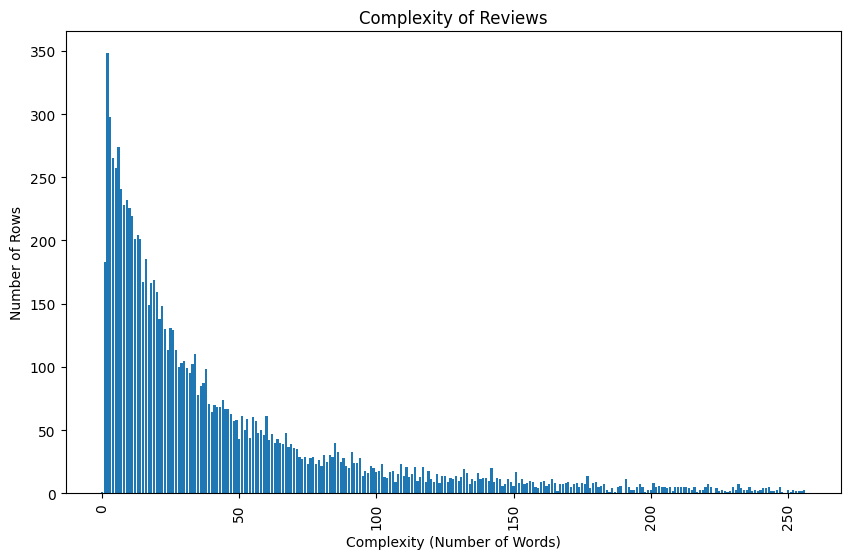

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize

# Download the punkt tokenizer (if not already downloaded)
nltk.download('punkt')

# Function to count the number of words in a given text
def count_words(text):
    words = word_tokenize(text)
    return len(words)

# Apply the count_words function to each row of the review_body column
df['word_count'] = df['review_body'].apply(count_words)

# Group by the word_count and count how many rows have reviews of that length
word_count_df = df['word_count'].value_counts().reset_index()
word_count_df.columns = ['Complexity (Number of Words)', 'Number of Rows']

# Sort the DataFrame by the complexity (number of words) in ascending order
word_count_df.sort_values(by='Complexity (Number of Words)', inplace=True)

# Create a bar plot to visualize the complexity and the number of rows
plt.figure(figsize=(10, 6))
plt.bar(word_count_df['Complexity (Number of Words)'], word_count_df['Number of Rows'])
plt.xlabel('Complexity (Number of Words)')
plt.ylabel('Number of Rows')
plt.title('Complexity of Reviews')
plt.xticks(rotation=90)
plt.show()


In [7]:
df.groupby(['star_rating', 'label', 'data_type']).count()

review_headline  review_body  sentiment   
star_rating label data_type                                            
1           2     train                  907          907        907  \
                  val                    190          190        190   
2           2     train                  490          490        490   
                  val                     83           83         83   
3           1     train                  683          683        683   
                  val                    135          135        135   
4           0     train                 1330         1330       1330   
                  val                    261          261        261   
5           0     train                 4665         4665       4665   
                  val                   1256         1256       1256   

                             word_count  
star_rating label data_type              
1           2     train             907  
                  val               190  
2           2     train             490  
                  val                83  
3           1     train             683  
                  val               135  
4           0     train            1330  
                  val               261  
5           0     train            4665  
                  val              1256

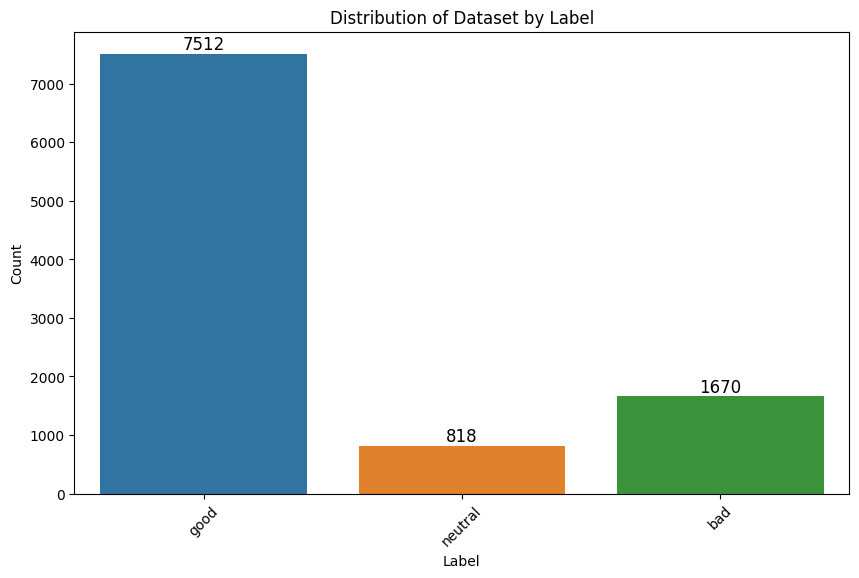

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the data already grouped as mentioned in your initial code
grouped_data = df.groupby(['label']).count()

# Reset the index to access the 'label' and 'data_type' columns
grouped_data.reset_index(inplace=True)

# Map numeric labels to text labels
label_mapping = {0: 'good', 1: 'neutral', 2: 'bad'}
grouped_data['label'] = grouped_data['label'].map(label_mapping)

# Create a bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='data_type', data=grouped_data)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Dataset by Label')

# Add count numbers as annotations to each bar
for index, row in grouped_data.iterrows():
    count = row['data_type']
    plt.text(index, count, str(count), ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45)
plt.show()


In [9]:
# Load BERT tokenizer
pretrained_path = 'gpt2'  # Replace with the path to the pretrained BERT model
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

encoded_data_train_headline = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].review_headline.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

encoded_data_train_body = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].review_body.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids_train_headline = encoded_data_train_headline['input_ids']
attention_masks_train_headline = encoded_data_train_headline['attention_mask']

input_ids_train_body = encoded_data_train_body['input_ids']
attention_masks_train_body = encoded_data_train_body['attention_mask']

input_ids_train = torch.cat((input_ids_train_headline, input_ids_train_body), dim=1)
attention_masks_train = torch.cat((attention_masks_train_headline, attention_masks_train_body), dim=1)

labels_train = torch.tensor(df[df.data_type=='train'].label.values)


encoded_data_val_headline = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].review_headline.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

encoded_data_val_body = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].review_body.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids_val_headline = encoded_data_val_headline['input_ids']
attention_masks_val_headline = encoded_data_val_headline['attention_mask']

input_ids_val_body = encoded_data_val_body['input_ids']
attention_masks_val_body = encoded_data_val_body['attention_mask']

input_ids_val = torch.cat((input_ids_val_headline, input_ids_val_body), dim=1)
attention_masks_val = torch.cat((attention_masks_val_headline, attention_masks_val_body), dim=1)

labels_val = torch.tensor(df[df.data_type=='val'].label.values)

In [10]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
len(dataset_train), len(dataset_val)

(8075, 1925)

In [11]:
from transformers import BertModel, BertConfig

num_classes = 3

class SentimentModel(nn.Module):
    def __init__(self, pretrained_path, num_classes, lstm_hidden_size):
        super(SentimentModel, self).__init__()

        bert_config = BertConfig.from_pretrained(
            pretrained_path,
            hidden_dropout_prob=0.3,
            attention_probs_dropout_prob=0.3
        )
        self.bert = BertModel.from_pretrained(pretrained_path, config=bert_config)

        self.dropout = nn.Dropout(0.2)
        self.lstm = nn.LSTM(bert_config.hidden_size, lstm_hidden_size, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        bert_outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = bert_outputs.pooler_output
        pooled_output = self.dropout(pooled_output)

        # Pass the pooled output through the LSTM layer
        lstm_output, _ = self.lstm(pooled_output.unsqueeze(0))
        lstm_output = lstm_output.squeeze(0)

        logits = self.fc(lstm_output)
        outputs = nn.functional.softmax(logits, dim=1)

        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, num_classes), labels.view(-1))
            return loss, outputs, labels
        else:
            return outputs

In [12]:
# Create model instance
pretrained_path = "bert-base-uncased"
lstm_hidden_size = 256
model = SentimentModel(pretrained_path, num_classes, lstm_hidden_size)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SentimentModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [14]:
# Count total params, trainable params, and non-trainable params
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params

# Print the results
print(f"Total Params: {total_params}")
print(f"Trainable Params: {trainable_params}")
print(f"Non-trainable Params: {non_trainable_params}")

Total Params: 110533635
Trainable Params: 110533635
Non-trainable Params: 0


In [15]:
from transformers import TrainingArguments, Trainer, logging
training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    fp16=True,
    **default_args,
)

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
)

In [17]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# Set the batch size and create data loaders for training and validation sets

batch_size = 8 #32

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=batch_size
)

In [18]:
from transformers import AdamW, get_linear_schedule_with_warmup

# Define the optimizer
optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
    eps=1e-8,
    weight_decay=0.01

)


epochs = 10
patience = 3
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train) * epochs
)

/home/z123010/anaconda3/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
import random

seed_val = 17
random.seed(seed_val) #sets the seed value for the Python built-in pseudo-random generator.
np.random.seed(seed_val) #sets the seed value for the NumPy pseudo-random number generator.
torch.manual_seed(seed_val) #sets the seed value for the random number generator in PyTorch on the CPU.
torch.cuda.manual_seed_all(seed_val) #sets the seed value for the random number generator in PyTorch on the GPU.

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda



Fold 1


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.5195653623910529
Validation loss: 0.37369660092609946
F1 Score (weighted): 0.8436917070590682


Epoch 2:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.3283824434222672
Validation loss: 0.3422797057768422
F1 Score (weighted): 0.8861262137743188
36.8% Training loss decreased compared to the previous epoch
8.41% Validation loss decreased compared to the previous epoch
5.03% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.25597314132518123
Validation loss: 0.34530201469234534
F1 Score (weighted): 0.8932702529990454
22.05% Training loss decreased compared to the previous epoch
0.88% Validation loss increased compared to the previous epoch
0.81% F1 Score increased compared to the previous epoch


Epoch 4:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.21912337000548637
Validation loss: 0.3788858325045445
F1 Score (weighted): 0.8975526350049822
14.4% Training loss decreased compared to the previous epoch
9.73% Validation loss increased compared to the previous epoch
0.48% F1 Score increased compared to the previous epoch


Epoch 5:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.1845837700792178
Validation loss: 0.39441049190026034
F1 Score (weighted): 0.9006553631127668
15.76% Training loss decreased compared to the previous epoch
4.1% Validation loss increased compared to the previous epoch
0.35% F1 Score increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 18.033658516407012 minutes
Final Accuracy: 0.908359133126935
Final Precision: 0.8994736726200951


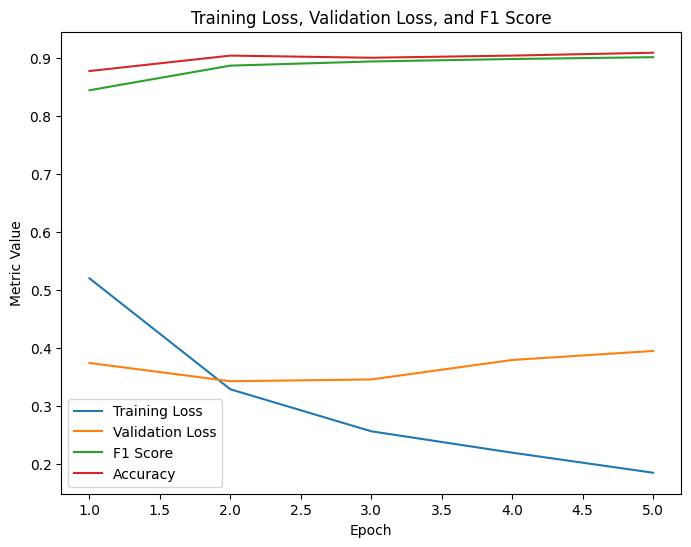

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.5195653623910529   0.37369660092609946  0.8436917070590682  0.8767801857585139     0.898069
2                     0.3283824434222672   0.3422797057768422   0.8861262137743188  0.8861262137743188     0.886126
3                     0.25597314132518123  0.34530201469234534  0.8932702529990454  0.8932702529990454     0.89327
4                     0.21912337000548637  0.3788858325045445   0.8975526350049822  0.8975526350049822     0.897553
5                     0.1845837700792178   0.39441049190026034  0.9006553631127668  0.9006553631127668     0.900655
Total Training Time                                                                                     1082.02
Final Precision                                                              

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.21972563855106814
Validation loss: 0.16210863280852353
F1 Score (weighted): 0.9513158143689665


Epoch 2:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.19360149359834233
Validation loss: 0.1303978579390868
F1 Score (weighted): 0.9603421587306182
11.89% Training loss decreased compared to the previous epoch
19.56% Validation loss decreased compared to the previous epoch
0.95% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.1721262113210782
Validation loss: 0.13592762734146216
F1 Score (weighted): 0.9603039623359806
11.09% Training loss decreased compared to the previous epoch
4.24% Validation loss increased compared to the previous epoch
0.0% F1 Score decreased compared to the previous epoch


Epoch 4:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.1510939372894769
Validation loss: 0.15027142546743635
F1 Score (weighted): 0.9584810529380765
12.22% Training loss decreased compared to the previous epoch
10.55% Validation loss increased compared to the previous epoch
0.19% F1 Score decreased compared to the previous epoch


Epoch 5:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.13809985476131043
Validation loss: 0.13826694151174534
F1 Score (weighted): 0.964043424841733
8.6% Training loss decreased compared to the previous epoch
7.99% Validation loss decreased compared to the previous epoch
0.58% F1 Score increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 18.00935767889023 minutes
Final Accuracy: 0.9647058823529412
Final Precision: 0.9639396940620018


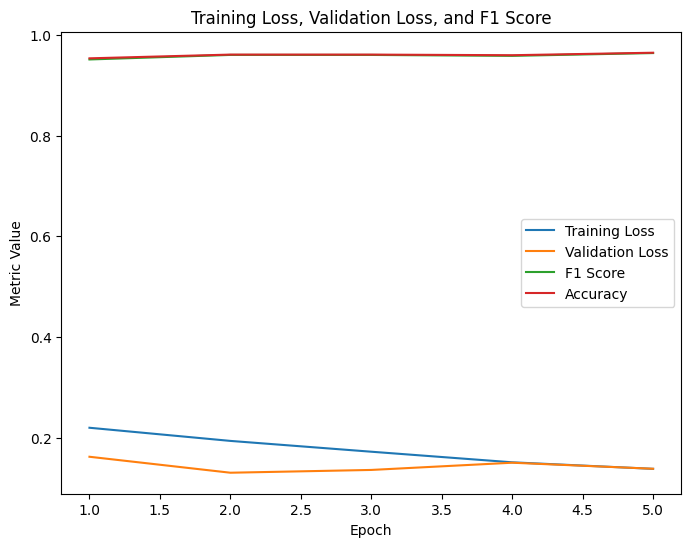

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.21972563855106814  0.16210863280852353  0.9513158143689665  0.9535603715170279     0.950989
2                     0.19360149359834233  0.1303978579390868   0.9603421587306182  0.9603421587306182     0.960342
3                     0.1721262113210782   0.13592762734146216  0.9603039623359806  0.9603039623359806     0.960304
4                     0.1510939372894769   0.15027142546743635  0.9584810529380765  0.9584810529380765     0.958481
5                     0.13809985476131043  0.13826694151174534  0.964043424841733   0.964043424841733      0.964043
Total Training Time                                                                                     1080.56
Final Precision                                                             

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.14672357182647794
Validation loss: 0.06007770149009579
F1 Score (weighted): 0.9868144656482952


Epoch 2:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.1353806057695062
Validation loss: 0.06127021190973165
F1 Score (weighted): 0.9874675453271984
7.73% Training loss decreased compared to the previous epoch
1.98% Validation loss increased compared to the previous epoch
0.07% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.1365638074646923
Validation loss: 0.06000323600820404
F1 Score (weighted): 0.9868144656482952
0.87% Training loss increased compared to the previous epoch
2.07% Validation loss decreased compared to the previous epoch
0.07% F1 Score decreased compared to the previous epoch


Epoch 4:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.12445201263457564
Validation loss: 0.060396948515778724
F1 Score (weighted): 0.9868144656482952
8.87% Training loss decreased compared to the previous epoch
0.66% Validation loss increased compared to the previous epoch


Epoch 5:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.12917744735080638
Validation loss: 0.06133300375416967
F1 Score (weighted): 0.9868144656482952
3.8% Training loss increased compared to the previous epoch
1.55% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.12679565139057225
Validation loss: 0.05966535892330645
F1 Score (weighted): 0.9868144656482952
1.84% Training loss decreased compared to the previous epoch
2.72% Validation loss decreased compared to the previous epoch


Epoch 7:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.13051784046828208
Validation loss: 0.060631483192163715
F1 Score (weighted): 0.9868144656482952
2.94% Training loss increased compared to the previous epoch
1.62% Validation loss increased compared to the previous epoch


Epoch 8:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.12708802917977394
Validation loss: 0.061754129020183686
F1 Score (weighted): 0.9868208981977488
2.63% Training loss decreased compared to the previous epoch
1.85% Validation loss increased compared to the previous epoch
0.0% F1 Score increased compared to the previous epoch


Epoch 9:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.1283576188188007
Validation loss: 0.06184900889177761
F1 Score (weighted): 0.9868144656482952
1.0% Training loss increased compared to the previous epoch
0.15% Validation loss increased compared to the previous epoch
0.0% F1 Score decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 32.403162598609924 minutes
Final Accuracy: 0.9869969040247678
Final Precision: 0.9868516518936208


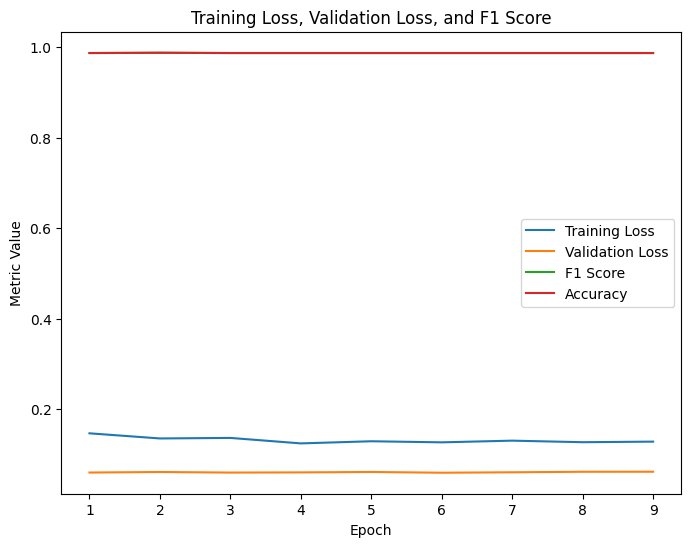

Epoch                 Training Loss        Validation Loss       F1 Score            Accuracy              Precision
--------------------  -------------------  --------------------  ------------------  ------------------  -----------
1                     0.14672357182647794  0.06007770149009579   0.9868144656482952  0.9869969040247678     0.986852
2                     0.1353806057695062   0.06127021190973165   0.9874675453271984  0.9874675453271984     0.987468
3                     0.1365638074646923   0.06000323600820404   0.9868144656482952  0.9868144656482952     0.986814
4                     0.12445201263457564  0.060396948515778724  0.9868144656482952  0.9868144656482952     0.986814
5                     0.12917744735080638  0.06133300375416967   0.9868144656482952  0.9868144656482952     0.986814
6                     0.12679565139057225  0.05966535892330645   0.9868144656482952  0.9868144656482952     0.986814
7                     0.13051784046828208  0.060631483192163715 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.12468518867687031
Validation loss: 0.06859125947063364
F1 Score (weighted): 0.9825552449831412


Epoch 2:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.13127263597821318
Validation loss: 0.06653788941681828
F1 Score (weighted): 0.9832097873354417
5.28% Training loss increased compared to the previous epoch
2.99% Validation loss decreased compared to the previous epoch
0.07% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.12567450399386654
Validation loss: 0.0689942809190638
F1 Score (weighted): 0.9825552449831412
4.26% Training loss decreased compared to the previous epoch
3.69% Validation loss increased compared to the previous epoch
0.07% F1 Score decreased compared to the previous epoch


Epoch 4:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.12384337013458262
Validation loss: 0.06697195957905824
F1 Score (weighted): 0.9832036073242957
1.46% Training loss decreased compared to the previous epoch
2.93% Validation loss decreased compared to the previous epoch
0.07% F1 Score increased compared to the previous epoch


Epoch 5:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.12044538049307411
Validation loss: 0.06862113599107592
F1 Score (weighted): 0.9818982802940074
2.74% Training loss decreased compared to the previous epoch
2.46% Validation loss increased compared to the previous epoch
0.13% F1 Score decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 18.008677264054615 minutes
Final Accuracy: 0.9820433436532507
Final Precision: 0.9818244898254872


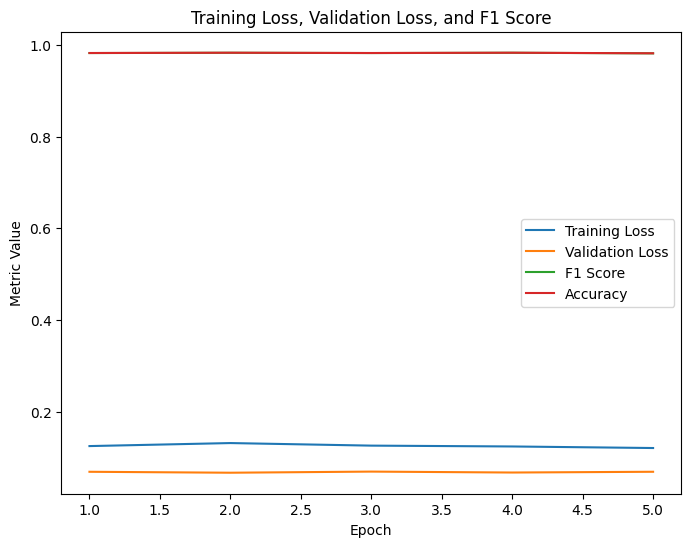

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.12468518867687031  0.06859125947063364  0.9825552449831412  0.9826625386996904     0.982499
2                     0.13127263597821318  0.06653788941681828  0.9832097873354417  0.9832097873354417     0.98321
3                     0.12567450399386654  0.0689942809190638   0.9825552449831412  0.9825552449831412     0.982555
4                     0.12384337013458262  0.06697195957905824  0.9832036073242957  0.9832036073242957     0.983204
5                     0.12044538049307411  0.06862113599107592  0.9818982802940074  0.9818982802940074     0.981898
Total Training Time                                                                                     1080.52
Final Precision                                                              

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.12000308000386951
Validation loss: 0.06870750939395132
F1 Score (weighted): 0.9856860590657169


Epoch 2:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.12729755890026048
Validation loss: 0.0676192728264285
F1 Score (weighted): 0.9856860590657169
6.08% Training loss increased compared to the previous epoch
1.58% Validation loss decreased compared to the previous epoch


Epoch 3:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.12624874585803764
Validation loss: 0.06611579232895286
F1 Score (weighted): 0.9856860590657169
0.82% Training loss decreased compared to the previous epoch
2.22% Validation loss decreased compared to the previous epoch


Epoch 4:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.11552411097702386
Validation loss: 0.06611391498723372
F1 Score (weighted): 0.9850382946200846
8.49% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch
0.07% F1 Score decreased compared to the previous epoch


Epoch 5:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.12270005903982484
Validation loss: 0.06639724105278418
F1 Score (weighted): 0.9856860590657169
6.21% Training loss increased compared to the previous epoch
0.43% Validation loss increased compared to the previous epoch
0.07% F1 Score increased compared to the previous epoch


Epoch 6:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.1147968402888227
Validation loss: 0.06890905035214757
F1 Score (weighted): 0.9850382946200846
6.44% Training loss decreased compared to the previous epoch
3.78% Validation loss increased compared to the previous epoch
0.07% F1 Score decreased compared to the previous epoch


Epoch 7:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.11736140697087982
Validation loss: 0.0687933646339582
F1 Score (weighted): 0.9850816658932648
2.23% Training loss increased compared to the previous epoch
0.17% Validation loss decreased compared to the previous epoch
0.0% F1 Score increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 25.212973872820537 minutes
Final Accuracy: 0.9851393188854489
Final Precision: 0.9851451160238888


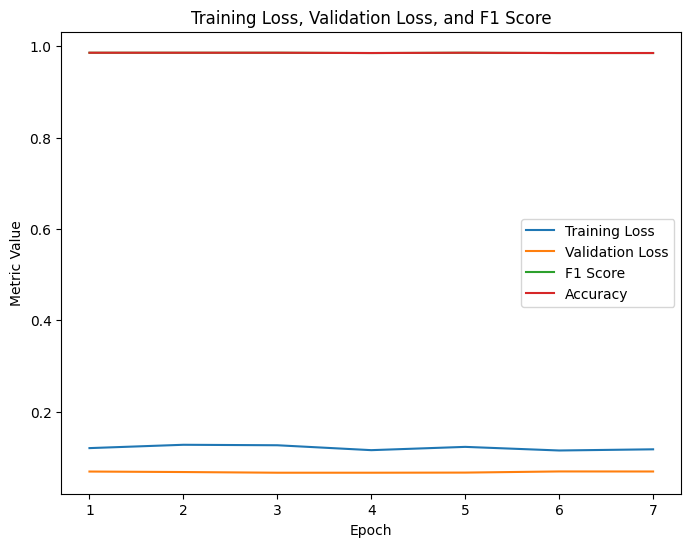

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.12000308000386951  0.06870750939395132  0.9856860590657169  0.9857585139318885     0.985757
2                     0.12729755890026048  0.0676192728264285   0.9856860590657169  0.9856860590657169     0.985686
3                     0.12624874585803764  0.06611579232895286  0.9856860590657169  0.9856860590657169     0.985686
4                     0.11552411097702386  0.06611391498723372  0.9850382946200846  0.9850382946200846     0.985038
5                     0.12270005903982484  0.06639724105278418  0.9856860590657169  0.9856860590657169     0.985686
6                     0.1147968402888227   0.06890905035214757  0.9850382946200846  0.9850382946200846     0.985038
7                     0.11736140697087982  0.0687933646339582   0.985081

In [21]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold

k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Convert the multilabel indicator target to numpy array
targets = dataset_train.tensors[1].numpy()

# Initialize lists to store the evaluation metrics for each fold
training_loss_lists = []
validation_loss_lists = []
accuracy_lists = []
precision_lists = []
f1_score_lists = []

# Perform multilabel k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(targets)):
    print(f"\nFold {fold+1}")
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

    # Create data loaders for training and validation
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, sampler=train_sampler)
    dataloader_vals = DataLoader(dataset_train, batch_size=batch_size, sampler=val_sampler)

    # Initialize metrics lists for this fold
    fold_training_loss_list = []
    fold_validation_loss_list = []
    fold_accuracy_list = []
    fold_precision_list = []
    fold_f1_score_list = []

    try:
        fold_training_loss_list, fold_validation_loss_list, fold_accuracy_list, fold_precision_list, fold_f1_score_list = \
        train_model(trainer, dataloader_train, dataloader_vals, epochs, patience)
    except Exception as e:
        print(f"Continue to the next fold {fold+1}: {str(e)}")
        continue

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.11805624562623394
Validation loss: 0.3318981105525479
F1 Score (weighted): 0.9240660951696524


Epoch 2:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.13199084682985426
Validation loss: 0.33342159785768904
F1 Score (weighted): 0.9235503926903136
11.8% Training loss increased compared to the previous epoch
0.46% Validation loss increased compared to the previous epoch
0.06% F1 Score decreased compared to the previous epoch


Epoch 3:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.12131903739674893
Validation loss: 0.3341451889537739
F1 Score (weighted): 0.9240660951696524
8.09% Training loss decreased compared to the previous epoch
0.22% Validation loss increased compared to the previous epoch
0.06% F1 Score increased compared to the previous epoch


Epoch 4:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.12006993798364995
Validation loss: 0.3318025171669795
F1 Score (weighted): 0.9235503926903136
1.03% Training loss decreased compared to the previous epoch
0.7% Validation loss decreased compared to the previous epoch
0.06% F1 Score decreased compared to the previous epoch


Epoch 5:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.12243448080734746
Validation loss: 0.3315260075177626
F1 Score (weighted): 0.9244736837409285
1.97% Training loss increased compared to the previous epoch
0.08% Validation loss decreased compared to the previous epoch
0.1% F1 Score increased compared to the previous epoch


Epoch 6:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.11683549649456151
Validation loss: 0.33769426566038546
F1 Score (weighted): 0.9240468559586571
4.57% Training loss decreased compared to the previous epoch
1.86% Validation loss increased compared to the previous epoch
0.05% F1 Score decreased compared to the previous epoch


Epoch 7:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.12132671713946608
Validation loss: 0.33088213792437865
F1 Score (weighted): 0.9240660951696524
3.84% Training loss increased compared to the previous epoch
2.02% Validation loss decreased compared to the previous epoch
0.0% F1 Score increased compared to the previous epoch


Epoch 8:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.11353962621588196
Validation loss: 0.3315123203297482
F1 Score (weighted): 0.9243857656643351
6.42% Training loss decreased compared to the previous epoch
0.19% Validation loss increased compared to the previous epoch
0.03% F1 Score increased compared to the previous epoch


Epoch 9:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.11876239775251228
Validation loss: 0.33417811772121403
F1 Score (weighted): 0.9240468559586571
4.6% Training loss increased compared to the previous epoch
0.8% Validation loss increased compared to the previous epoch
0.04% F1 Score decreased compared to the previous epoch


Epoch 10:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.12190088045398363
Validation loss: 0.329315543470854
F1 Score (weighted): 0.9240468559586571
2.64% Training loss increased compared to the previous epoch
1.46% Validation loss decreased compared to the previous epoch

Total training time: 36.04713096221288 minutes
Final Accuracy: 0.9246753246753247
Final Precision: 0.9234652621073781


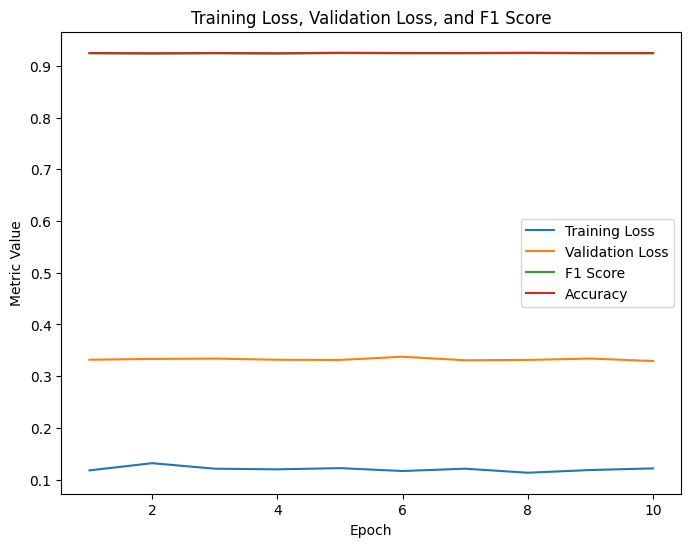

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.11805624562623394  0.3318981105525479   0.9240660951696524  0.9246753246753247     0.923509
2                     0.13199084682985426  0.33342159785768904  0.9235503926903136  0.9235503926903136     0.92355
3                     0.12131903739674893  0.3341451889537739   0.9240660951696524  0.9240660951696524     0.924066
4                     0.12006993798364995  0.3318025171669795   0.9235503926903136  0.9235503926903136     0.92355
5                     0.12243448080734746  0.3315260075177626   0.9244736837409285  0.9244736837409285     0.924474
6                     0.11683549649456151  0.33769426566038546  0.9240468559586571  0.9240468559586571     0.924047
7                     0.12132671713946608  0.33088213792437865  0.92406609

([0.11805624562623394,
  0.13199084682985426,
  0.12131903739674893,
  0.12006993798364995,
  0.12243448080734746,
  0.11683549649456151,
  0.12132671713946608,
  0.11353962621588196,
  0.11876239775251228,
  0.12190088045398363],
 [0.3318981105525479,
  0.33342159785768904,
  0.3341451889537739,
  0.3318025171669795,
  0.3315260075177626,
  0.33769426566038546,
  0.33088213792437865,
  0.3315123203297482,
  0.33417811772121403,
  0.329315543470854],
 [0.9246753246753247,
  0.9241558441558442,
  0.9246753246753247,
  0.9241558441558442,
  0.9251948051948052,
  0.9246753246753247,
  0.9246753246753247,
  0.9251948051948052,
  0.9246753246753247,
  0.9246753246753247],
 [0.923508728684533,
  0.9229967496887996,
  0.923508728684533,
  0.9229967496887996,
  0.9238195342207669,
  0.9234652621073781,
  0.923508728684533,
  0.9236678436692092,
  0.9234652621073781,
  0.9234652621073781],
 [0.9240660951696524,
  0.9235503926903136,
  0.9240660951696524,
  0.9235503926903136,
  0.92447368374092

In [22]:
train_model(trainer, dataloader_train, dataloader_val, epochs, patience)